#### Using beautifulsoup i am going to extract the NSE advance decline ratio over the months. Make sure the latest version of pandas is updated

In [54]:
#pip install pandas == 1.4.3


##### I always like ignoring warnings

In [55]:
import warnings
warnings.filterwarnings('ignore')

#### We are going to create a date_list between 2 dates (starting and ending). This is going be used in create dynamic links in the for loop later on

In [56]:
import datetime
import pandas as pd

start_date = datetime.datetime(2022,1,1)
end_date = datetime.datetime(2022,6,30)

date_list = pd.date_range(start_date,end_date,freq = 'M',inclusive="both").strftime("%b%Y")
date_list = date_list.str.lower()

##### For loop starts here. We are going to create and empty dataframe df and store the results in the dataframe. The for loop uses beautiful soup for scrapping html

In [57]:
import requests
import json
from requests.auth import HTTPBasicAuth


from bs4 import BeautifulSoup

df = pd.DataFrame()

for i in date_list:
    url = 'https://www1.nseindia.com/products/content/equities/equities/eq_advdec'+ i + '.htm'
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = requests.get(url,headers=headers,auth=HTTPBasicAuth('user', 'pass'))
    soup = BeautifulSoup(page.text, 'html.parser')
    
    table = soup.find('table')
    rows = table.find_all('tr')
    
    for row in rows:
        try:
            date = row.find('td',attrs = {'class':'date'}).get_text()
            adv = int(row.find_all('td',attrs = {'class':'number'})[0].get_text())
            dec = int(row.find_all('td',attrs = {'class':'number'})[1].get_text())
            adv_dec_ratio = float(row.find_all('td',attrs = {'class':'number'})[2].get_text())
            output = pd.DataFrame([[date,adv,dec,adv_dec_ratio]],columns=['Date','Adv','Dec','Adv_Dec_Ratio'])
            df = df.append(output)
        except:
            pass



In [58]:
df.head(n=2)

,Date,Adv,Dec,Adv_Dec_Ratio
0,03-Jan-2022,1619,544,2.98
0,04-Jan-2022,1115,1013,1.10


##### Converting the date variable from format string to date, and adding a new variable called adv_ratio

In [59]:
df['Date'] = pd.to_datetime(df['Date'])
df['Adv_Ratio'] =df['Adv']/(df['Adv'] + df['Dec'])

In [60]:
df.head(n=2)


,Date,Adv,Dec,Adv_Dec_Ratio,Adv_Ratio
0,2022-01-03,1619,544,2.98,0.748497
0,2022-01-04,1115,1013,1.10,0.523966


#### Lets plot a simple line chart

<AxesSubplot:xlabel='Date'>

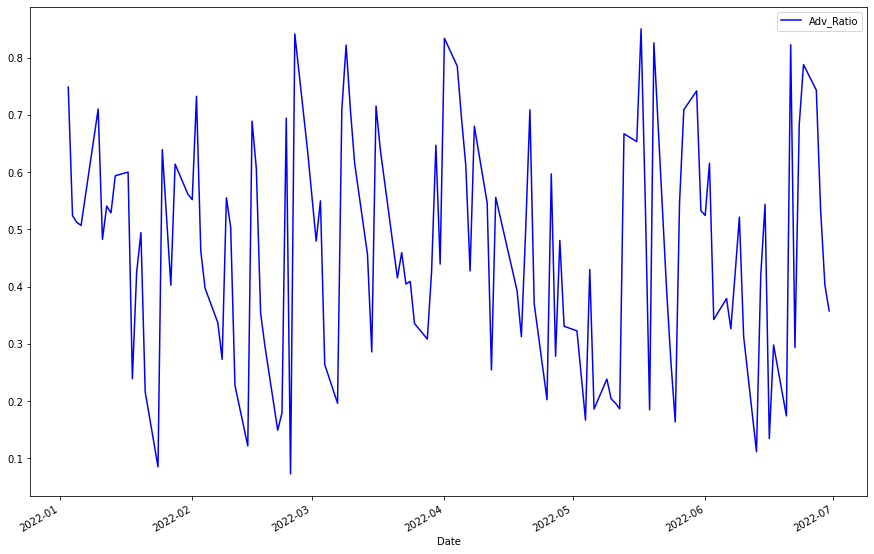

In [64]:
df.plot(x = 'Date' , y = 'Adv_Ratio' , figsize = (15,10) , color = 'blue')

#### The line plot does not give much information. Hence i proceed creating a matrix x indexed by month with column being days of the month. We will use this to create a heatmap

In [65]:
x = pd.pivot_table(df,values = 'Adv_Ratio',index = df['Date'].dt.strftime('%d') , columns = df['Date'].dt.strftime('%Y-%m'))

In [66]:
x.head(n=5)

Date,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06
Date,,,,,,
01,NaN,0.551871,NaN,0.833723,NaN,0.524304
02,NaN,0.732487,0.479458,NaN,0.322700,0.615494
03,0.748497,0.462553,0.549858,NaN,NaN,0.342510
04,0.523966,0.397332,0.263876,0.785185,0.167049,NaN
05,0.512184,NaN,NaN,0.694211,0.429706,NaN


##### The last step is to create a heatmap. The whitespaces in the map are basically holidays or non trading days

Text(0.5, 1.0, 'Advance Decline HeatMap')

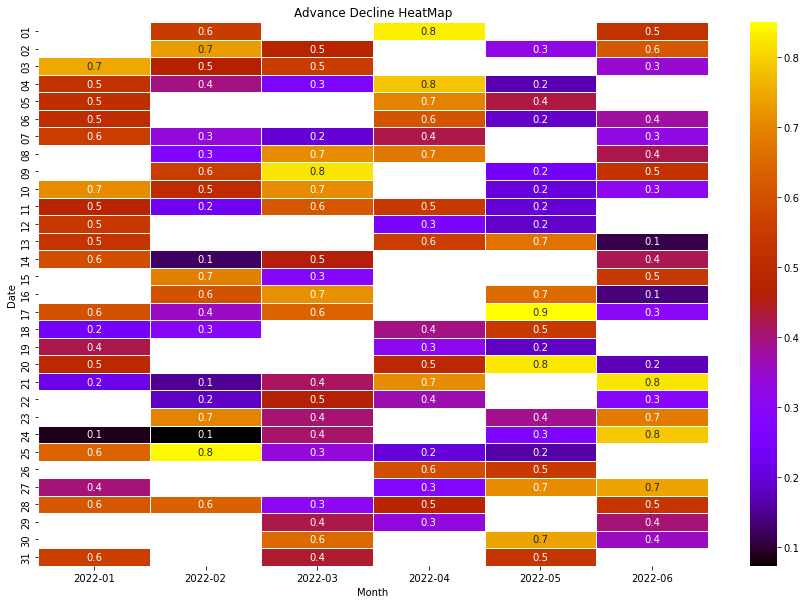

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.heatmap(x, annot = True, fmt = '.1f' ,cmap = 'gnuplot' , linewidth = 1)
plt.xlabel('Month')
plt.title('Advance Decline HeatMap')